Random Forest Test Accuracy: 0.8966101694915254
Confusion Matrix:
 [[521   4]
 [ 57   8]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.99      0.94       525
    Positive       0.67      0.12      0.21        65

    accuracy                           0.90       590
   macro avg       0.78      0.56      0.58       590
weighted avg       0.88      0.90      0.86       590



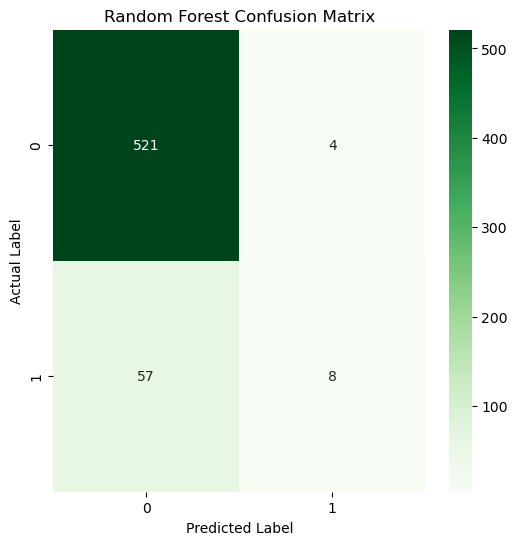

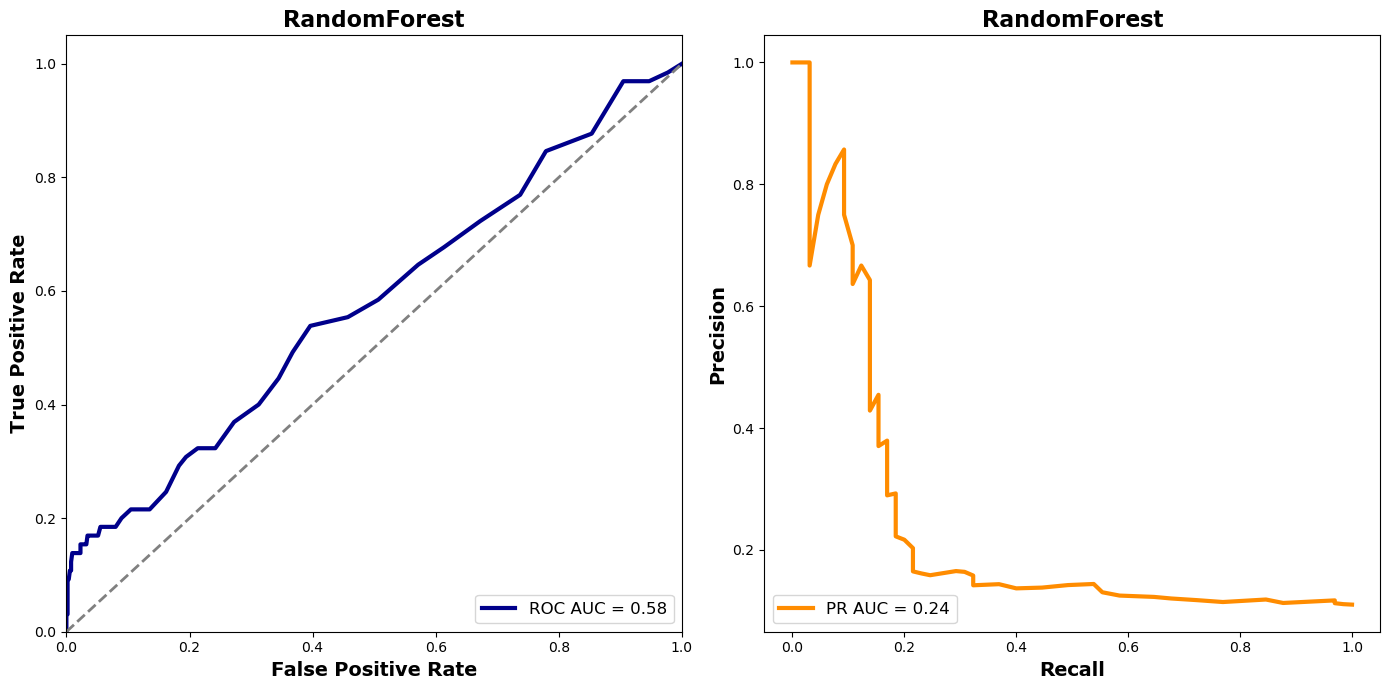

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

# Set the dataset directory path
data_directory = r'C:\Users\ADMIN\Downloads\Ann\Dataset\kaggle_3m'

# Function to determine the class label from the file path
def extract_label(file_path):
    return 1 if "1." in file_path else 0

# Retrieve all image paths within the dataset
image_path_list = glob(os.path.join(data_directory, '**', '*.tif'), recursive=True)

# Separate paths for images and corresponding masks
mask_paths = [p for p in image_path_list if "_mask" in p]
image_paths = [p for p in image_path_list if "_mask" not in p]

# Get labels for each image
labels_list = [extract_label(p) for p in image_paths]

# Split dataset into training, validation, and testing subsets
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    image_paths, labels_list, test_size=0.15, random_state=42)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    train_imgs, train_labels, test_size=0.1, random_state=42)

# Function to load and preprocess images
def load_and_preprocess_image(file_path, target_dims=(256, 256)):
    img = Image.open(file_path)
    img = img.resize(target_dims)
    img = np.array(img)
    img = img / 255.0  # Normalize image data to [0, 1]
    return img

# Preprocess all image data
train_img_data = np.array([load_and_preprocess_image(p) for p in train_imgs])
val_img_data = np.array([load_and_preprocess_image(p) for p in val_imgs])
test_img_data = np.array([load_and_preprocess_image(p) for p in test_imgs])

# Flatten the image data for input to the Random Forest model
train_img_data_flat = train_img_data.reshape(train_img_data.shape[0], -1)
val_img_data_flat = val_img_data.reshape(val_img_data.shape[0], -1)
test_img_data_flat = test_img_data.reshape(test_img_data.shape[0], -1)

# Initialize and train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_img_data_flat, train_labels)

# Make predictions on the test set
test_preds = rf_classifier.predict(test_img_data_flat)

# Compute accuracy, confusion matrix, and classification report
test_acc = accuracy_score(test_labels, test_preds)
conf_matrix = confusion_matrix(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds, target_names=["Negative", "Positive"])

print("Random Forest Test Accuracy:", test_acc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Calculate probabilities and performance metrics for ROC and PR curves
predicted_probabilities = rf_classifier.predict_proba(test_img_data_flat)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, predicted_probabilities)
roc_auc_value = roc_auc_score(test_labels, predicted_probabilities)
prec, rec, _ = precision_recall_curve(test_labels, predicted_probabilities)
pr_auc_value = auc(rec, prec)

# Plot ROC and Precision-Recall curves
plt.figure(figsize=(14, 7))

# ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkblue', lw=3, label='ROC AUC = {:.2f}'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', fontname='Verdana')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', fontname='Verdana')
plt.title('RandomForest', fontsize=16, fontweight='bold', fontname='Verdana')
plt.legend(loc="lower right", fontsize=12)

# Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(rec, prec, color='darkorange', lw=3, label='PR AUC = {:.2f}'.format(pr_auc_value))
plt.xlabel('Recall', fontsize=14, fontweight='bold', fontname='Verdana')
plt.ylabel('Precision', fontsize=14, fontweight='bold', fontname='Verdana')
plt.title('RandomForest', fontsize=16, fontweight='bold', fontname='Verdana')
plt.legend(loc="lower left", fontsize=12)

plt.tight_layout()
plt.show()
